# Vision Transformer basic tutorial - ViT

<a href="https://colab.research.google.com/github/mulkong/ViT_tutorial-pytorch/blob/main/01.%20Vision_Transformer_basic_tutorial-MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq einops
!pip install -Uqq ipywidgets
!pip install -Uqq torchsummary


In [15]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Wed Dec 29 11:00:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   50C    P0    74W / 300W |  13330MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torchvision
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets


# Vision Transformer Architecture - pytorch
* * * 

## 특징
- NLP 분야에서 사용된 Transformerd를 응용하여 Vision task에서 사용할 수 있도록 고안된 첫 논문 -> ViT
- Transformer만 사용해서 image classificaiton task에 적용
- 논문에서 Architecture의 hyper-parameter에 따라 여러가지 모델들을 제안하고 있음.
<img src="imgs/vit table1.png"> 

## 학습 과정

<img src="imgs/ViT Architecture gif.gif">


1. 이미지 입력 
    - 논문에서는 224x224x3 이미지
2. patch로 자름
    - 논문에서는 16 x 16로 자름.
3. 각각의 patch들을 1D-vector로 풀어냄
4. 1D vector로 만들어진 patch들을 Linear Projection을 통해 각 patch의 embedding vector로 표현.
    - 논문상에서는 768차원의 patch embedding vector로 표현.
5. 각 patch embedding에 classification token, position embedding 추가.
6. Transformer Encoder
7. Transformer output
8. classification 수행


---



# 1. Linear Projection of Flattened Patches
## 1-1. Patch Embedding
- 1d vector로 만들어진 patch들을 Linear Projection(nn.Linear or nn.Conv2D 사용)을 통해 표현된 patch embedding vector에 cls_token, position embedding 추가함

## 1-2. classification token(=cls_token)
- classification을 위해 사용되는 token이며 **학습을 통해 결정되는 parameter**

## 1-3. position embedding
- patch의 위치 정보를 가지고 있는 embedding
- position embedding을 사용 안하면?
    - 이미지 입력 -> 일정한 크기의 patch로 자름 -> 자른 patch를 sequence로 생각하여 transformer Encoder로 입력 -> 각 patch가 어떤 위치에서 왔는지 위치 정보가 손실 -> 학습 안됨

#### 따라서, Transformer Encoder에 입력되는 parameter는 (classification token, patch embedding) + position embedding이다.
<img src="imgs/figure_vit_1.png"> </br>

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int=3, patch_size:int=16, emb_size:int=768, img_size:int=224):
        super().__init__()
        self.patch_size = patch_size
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e')
        )
        # 학습에 의헤 결정되는 parameter
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))
        
    def forward(self, x:Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions 
        
        return x

# 2. Transformer Encoder

## 2-1. NLP Transformer Encoder vs Vision Transformer Encoder
- Transformer는 `layer를 깊게 쌓으면 학습이 어렵다`라는 단점이 존재한다.
    - 이런 단점을 극복하여 학습이 이루어지게 하기 위해서는 `layer normalization의 위치가 중요하다`라는 것이 후속 연구들을 통해 증명이 되었다.

- ViT는 NLP 분야에서 보여진 `layer를 깊게 쌓으면 학습이 어렵다`라는 문제와 이를 극복하기 위해 `layer normalization의 위치가 중요하다`라는 연구를 받아드려 Vision Transformer Encoder에 적용시켰다.
    - 기존 Vanilla Transformer : Multi-head attention -> normalization
    - ViT: normalization -> Multi-head attention

<center>
    <img src="imgs/MLP Transformer Encoder.png", height="250px", width="250px"/>
    <img src="imgs/Transformer Encoder.png", height="250px", width="250px">
</center>
   

---
## 2-2. 입력 형태

위 그림에서 보면 `input Embedding`블럭을 거친 후 position encoding과 더해지는 부분이 있다. 그 부분을 코드로 작성하면 아래와 같다.


``` python
transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
```

그리고 본 튜토리얼에서 사용된 `PatchEmbedding class`에서는 다음과 forward 함수에서 같이 사용되었다.
```python
x = torch.cat([cls_tokens, x], dim=1)
x += self.positions 
```

## 2-3. Multi-head attention architecture
- ViT base model을 기준으로 말을 하면 self-attention을 12번 수행했다고 나와있다. ViT에서는 아래 그림 중 `Scaled Dot-Product Attention` 그림을 보면 된다.

<center>
    <img src="imgs/figure_vit_2.png", height="100%", width="100%"/>
</center>

### 2-3-1. Self-Attention
- 순서 1: layer normalization 거친 후 얻어진 $z$

- 순서 2: weight metrix $W_Q$,  $W_K$,  $W_V$에 곱해져서 Query, key, Value가 계산된다.
    
    ⭐️ 이떄, weight metrix의 학습을 통해 `attention`이 학습된다.
    
- 순서 3: Query, Key 값들의 `dot product[torch.einsum('bhqd, bhkd -> bhqk', queries, keys)]`를 통해 `Similarity 계산`
    - 각 이미지 패치들이 다른 모든 패치들과 얼마나 유사한지 파악을 하는데 도움을 줍니다.
    - NLP와 동일하게 안정적인 gradient를 얻기 위해 $Q /dot K^T$행렬에 key vector dimension의 제곱근값으로 나눈다.
    
- 순서 4: 위에서 계산된 값은 비정규화된 형태이다. 이를 Softmax를 취해 0 ~ 1의 attention score계산하여 정규화 작업을 진행한다.

- 순서 5: 계산된 attention score에 `Value`를 곱해 최종적인 output을 얻는다.

- ⭐️ `self-attention`은 query, key vector의 내적 연산 후 key 차원의 제곱근으로 나누기 때문에 `scaled dot proudct attention` 이라고도 한다.
<center>
    <img src="imgs/Multi-Head attention.png", height="100%", width="100%"/>
</center>

### 2-3-2. Multi-head self-attention

#### 개념
`attention 결과의 정확도를 높이기` 위해 `single head attention`말고 `multi-head attention`을 사용한 후 결과값을 더한다.

#### 순서
- 순서 1: layer normalization 거친 후 얻어진 768 차원의 $z$ 
- 순서 2: Multi-head self-attention 통과
- 순서 3: 64차원으로 감소
- 순서 4: self-attention을 12번 수행하니까 768차원으로 다시 증가
- 순서 5: 결국 차원 수가 입력일때와 동일하게 유지됨.

<center>
    <img src="imgs/figure_vit_3.png", height="100%", width="100%"/>
</center>


In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size:int=768, num_heads:int=8, dropout:float=0.):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # dot product: MatMul(Query, Keys)
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        # Scale
        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        
        # dot product: MatMul(attention, values)
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out      

## 2-4. MLP
MLP는 1개의 hidden layer로 구성되 FCN(Fully-connected latyer)이다.
<center>
    <img src="imgs/figure_vit_4.png", height="100%", width="100%"/>
</center>

In [22]:
class MLP(nn.Sequential):
    def __init__(self, emb_size:int, expansion:int=4, drop_p:float=0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size), # (768, 3072)
            nn.GELU(), # activation function
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size) # (3072, 768)
        )

## 2-5. Residual layer
residual addition을 계산하는 class를 만들어 줍니다.

자세한 내용은 residual network paper를 읽어보시거나 코드 구현체를 참고하시기 바랍니다.

In [6]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

## 2-6. Transformer Encoder Block
이제 아래 그림과 같이 위에서 구성해준 class를 사용해서 Transformer Encoder class를 구현해보겠습니다.
<center>
    <img src="imgs/Transformer Encoder.png", height="250px", width="250px">
</center>

In [25]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MLP(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

## 2-7. Transformer Encoder

In [8]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

마지막 계층인 MLP Head(classifictaion head)는 분류 작업을 할 클래스의 확률을 보여주는 fully connected layer 입니다.

확률을 보여주기 전에 전체 시퀀스(sequence)에 대해 reduction을 적용합니다.

In [9]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

# 3. ViT
PatchEmbedding, TransformerEncoder, ClassificationHead 클래스를 이용하여 최종적인 ViT Architecture를 구현합니다.

In [10]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )
        
summary(ViT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5            [-1, 197, 2304]       1,771,776
           Dropout-6          [-1, 8, 197, 197]               0
            Linear-7             [-1, 197, 768]         590,592
MultiHeadAttention-8             [-1, 197, 768]               0
           Dropout-9             [-1, 197, 768]               0
      ResidualAdd-10             [-1, 197, 768]               0
        LayerNorm-11             [-1, 197, 768]           1,536
           Linear-12            [-1, 197, 3072]       2,362,368
             GELU-13            [-1, 197, 3072]               0
          Dropout-14            [-1, 19

# 4. ViT를 이용해서 MNIST 분류 작업
- MNIST는 (28x28x1)이므로 ViT 논문에 나와있는 이미지와는 다르다. 따라서 28x28에 맞게끔 parameter를 수정해야 합니다.

# MNIST DataLoader

In [11]:
import time

BATCH_SIZE_TRAIN = 1024
BATCH_SIZE_TEST = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
transform_mnist = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST('/data/mnist', train=True, download=True,
                                       transform=transform_mnist)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

test_dataset = torchvision.datasets.MNIST('/data/mnist', train=False, download=True,
                                      transform=transform_mnist)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE_TEST, shuffle=True)

In [13]:
def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())

def evaluate(model, data_loader, loss_history):
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')
    
    
N_EPOCHS = 10

start_time = time.time()
# MNIST에 맞게 Hyper-parameter 수정.
model = ViT(in_channels=1, patch_size=7, emb_size=128, img_size=28, depth=64, n_classes=10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

train_loss_history, test_loss_history = [], []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, test_loader, test_loss_history)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')


Epoch: 1
[    0/60000 (  0%)]  Loss: 2.3608

Average test loss: 2.2755  Accuracy: 1141/10000 (11.41%)

Epoch: 2
[    0/60000 (  0%)]  Loss: 2.2721

Average test loss: 0.9613  Accuracy: 6751/10000 (67.51%)

Epoch: 3
[    0/60000 (  0%)]  Loss: 0.9662

Average test loss: 0.5506  Accuracy: 8211/10000 (82.11%)

Epoch: 4
[    0/60000 (  0%)]  Loss: 0.5761

Average test loss: 0.3705  Accuracy: 8878/10000 (88.78%)

Epoch: 5
[    0/60000 (  0%)]  Loss: 0.3964

Average test loss: 0.2672  Accuracy: 9151/10000 (91.51%)

Epoch: 6
[    0/60000 (  0%)]  Loss: 0.2644

Average test loss: 0.2323  Accuracy: 9291/10000 (92.91%)

Epoch: 7
[    0/60000 (  0%)]  Loss: 0.2442

Average test loss: 0.2008  Accuracy: 9372/10000 (93.72%)

Epoch: 8
[    0/60000 (  0%)]  Loss: 0.1976

Average test loss: 0.2015  Accuracy: 9360/10000 (93.60%)

Epoch: 9
[    0/60000 (  0%)]  Loss: 0.1794

Average test loss: 0.1689  Accuracy: 9449/10000 (94.49%)

Epoch: 10
[    0/60000 (  0%)]  Loss: 0.1933

Average test loss: 0.1711  

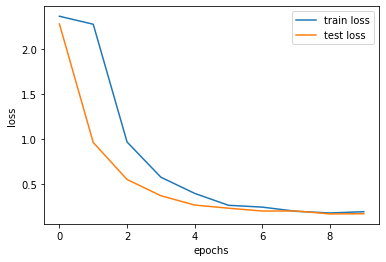

In [21]:
plt.plot(train_loss_history, label='train loss')
plt.plot(test_loss_history, label='test loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Reference
- https://github.com/FrancescoSaverioZuppichini/ViT#transformer-1
- https://arxiv.org/abs/2010.11929
- https://www.youtube.com/watch?v=bgsYOGhpxDc&t=580s
- https://blog.promedius.ai/transformer/
